In [1]:
import random
import copy
from pathlib import Path
from textwrap import dedent

import cv2
import torch
import mat73
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

tqdm.pandas()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATA_PATH = Path("./datasets/digits")
TEST_SIZE = 0.2
SEED = 42

# Utils

In [2]:
def xyxy2xywh(x):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] where xy1=top-left, xy2=bottom-right
    y = copy.deepcopy(x) if isinstance(x, list) else np.copy(x)
    y[0] = (x[0] + x[2]) / 2  # x center
    y[1] = (x[1] + x[3]) / 2  # y center
    y[2] = x[2] - x[0]  # width
    y[3] = x[3] - x[1]  # height
    return y


def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = copy.deepcopy(x) if isinstance(x, list) else np.copy(x)
    y[0] = x[0] - x[2] / 2  # top left x
    y[1] = x[1] - x[3] / 2  # top left y
    y[2] = x[0] + x[2] / 2  # bottom right x
    y[3] = x[1] + x[3] / 2  # bottom right y
    return y


def plot_img(img_path, coords, verbose=True):
    coords = np.copy(coords)
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    for c in coords:
        if max(c[:4]) <= 1:
            c[[0, 2]] *= w
            c[[1, 3]] *= h
        c = tuple(map(int, c[:4]))

        cv2.rectangle(
            img,
            c[:2],
            c[2:],
            (255, 0, 0),
            2
        )
    
    img = Image.fromarray(img)
    if verbose:
        plt.axis('off')
        plt.imshow(img)
    return img


# Prepare data

In [3]:
train_mat = mat73.loadmat(DATA_PATH / "train/digitStruct.mat")
test_mat = mat73.loadmat(DATA_PATH / "test/digitStruct.mat")

In [4]:
len(train_mat["digitStruct"]["bbox"]), len(test_mat["digitStruct"]["bbox"])

(33402, 13068)

In [5]:
def get_df(mat_data, stage="train"):
    data = []
    for img_name, d in tqdm(
        zip(
            mat_data["digitStruct"]["name"], 
            mat_data["digitStruct"]["bbox"]
        ), total=len(mat_data["digitStruct"]["bbox"])
    ):
        img_path = str(DATA_PATH / stage / img_name)
        img_height, img_width, _ = cv2.imread(img_path).shape

        for i in d:
            if isinstance(d[i], list):
                d[i] = np.stack(d[i])

        xyxy = [
            max(d["left"].min(), 0) / img_width, 
            max(d["top"].min(), 0) / img_height, 
            min((d["left"] + d["width"]).max(), img_width) / img_width, 
            min((d["top"] + d["height"]).max(), img_height) / img_height
        ]
        xywh = xyxy2xywh(xyxy)
        data.append({
            "img_path": img_path,
            "xyxy": np.array(xyxy),
            "xywh": np.array(xywh),
            "img_height": img_height,
            "img_width": img_width
        })

    return pd.DataFrame(data)


train_df = get_df(train_mat, stage="train")
test_df = get_df(test_mat, stage="test")

100%|██████████| 13068/13068 [00:07<00:00, 1658.56it/s]


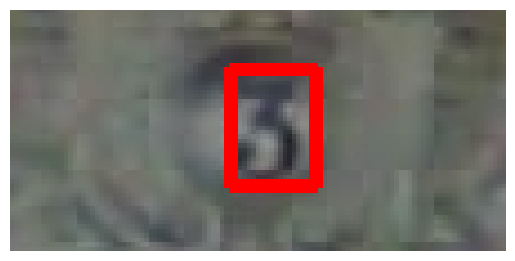

In [6]:
idx = random.randint(0, len(train_df) - 1)
_ = plot_img(train_df.iloc[idx].img_path, [train_df.iloc[idx].xyxy])

## Create yolo format dataset

In [7]:
train, val = train_test_split(train_df, test_size=TEST_SIZE, random_state=SEED)
print(f"Train: {len(train)} Val: {len(val)} Test: {len(test_df)}")


def save_for_yolo(r: pd.Series, stage="train"):
    img_path = Path(r.img_path)
    new_img_path = DATA_PATH / f"yolo_format/images/{stage}"
    new_img_path.mkdir(exist_ok=True, parents=True)
    (new_img_path / img_path.name).write_bytes(img_path.read_bytes())

    new_label_path = DATA_PATH / f"yolo_format/labels/{stage}"
    new_label_path.mkdir(exist_ok=True, parents=True)
    (new_label_path / (img_path.name.split(".")[0] + ".txt")).write_text("0 " + " ".join(map(str, r.xywh)))

for data, stage in zip([train, val, test_df], ["train", "val", "test"]):
    for _, row in tqdm(data.iterrows(), total=len(data)):
        save_for_yolo(row, stage)

Train: 26721 Val: 6681 Test: 13068


100%|██████████| 13068/13068 [00:04<00:00, 3108.55it/s]


In [21]:
data_config_txt = dedent(
"""path: /home/and/projects/itmo/itmo_image_rec_gen/02_object_detection/datasets/digits/yolo_format
train: images/train 
val: images/val
test: images/test

# Classes
nc: 1 # number of classes
names: ["number"]
""")
with open("./yolov5/data/digits.yaml", "w") as f:
    f.write(data_config_txt)

# Train Yolov5

In [22]:
! PYTHONPATH=$PWD/yolov5 python ./yolov5/train.py \
    --img 640 \
    --batch 32 \
    --epochs 10 \
    --data digits.yaml \
    --weights yolov5s.pt \
    --device 0 \
    --optimizer SGD \
    --workers 4 \
    --cache \
    --cos-lr

train: weights=yolov5s.pt, cfg=, data=digits.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=4, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=True, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
From github.com:ultralytics/yolov5
 * [new tag]           v7.0       -> v7.0
fatal: ambiguous argument 'HEAD..origin/master': unknown revision or path not in the working tree.
Use '--' to separate paths from revisions, like this:
'git <command> [<revision>...] -- [<file>...]'
Command 'git rev-list HEAD..origin/master --count' returned non-zero exit status 128.
YOLOv5 🚀 v6.2-0-gd3ea0df8 Python-3.10

# Validate yolov5

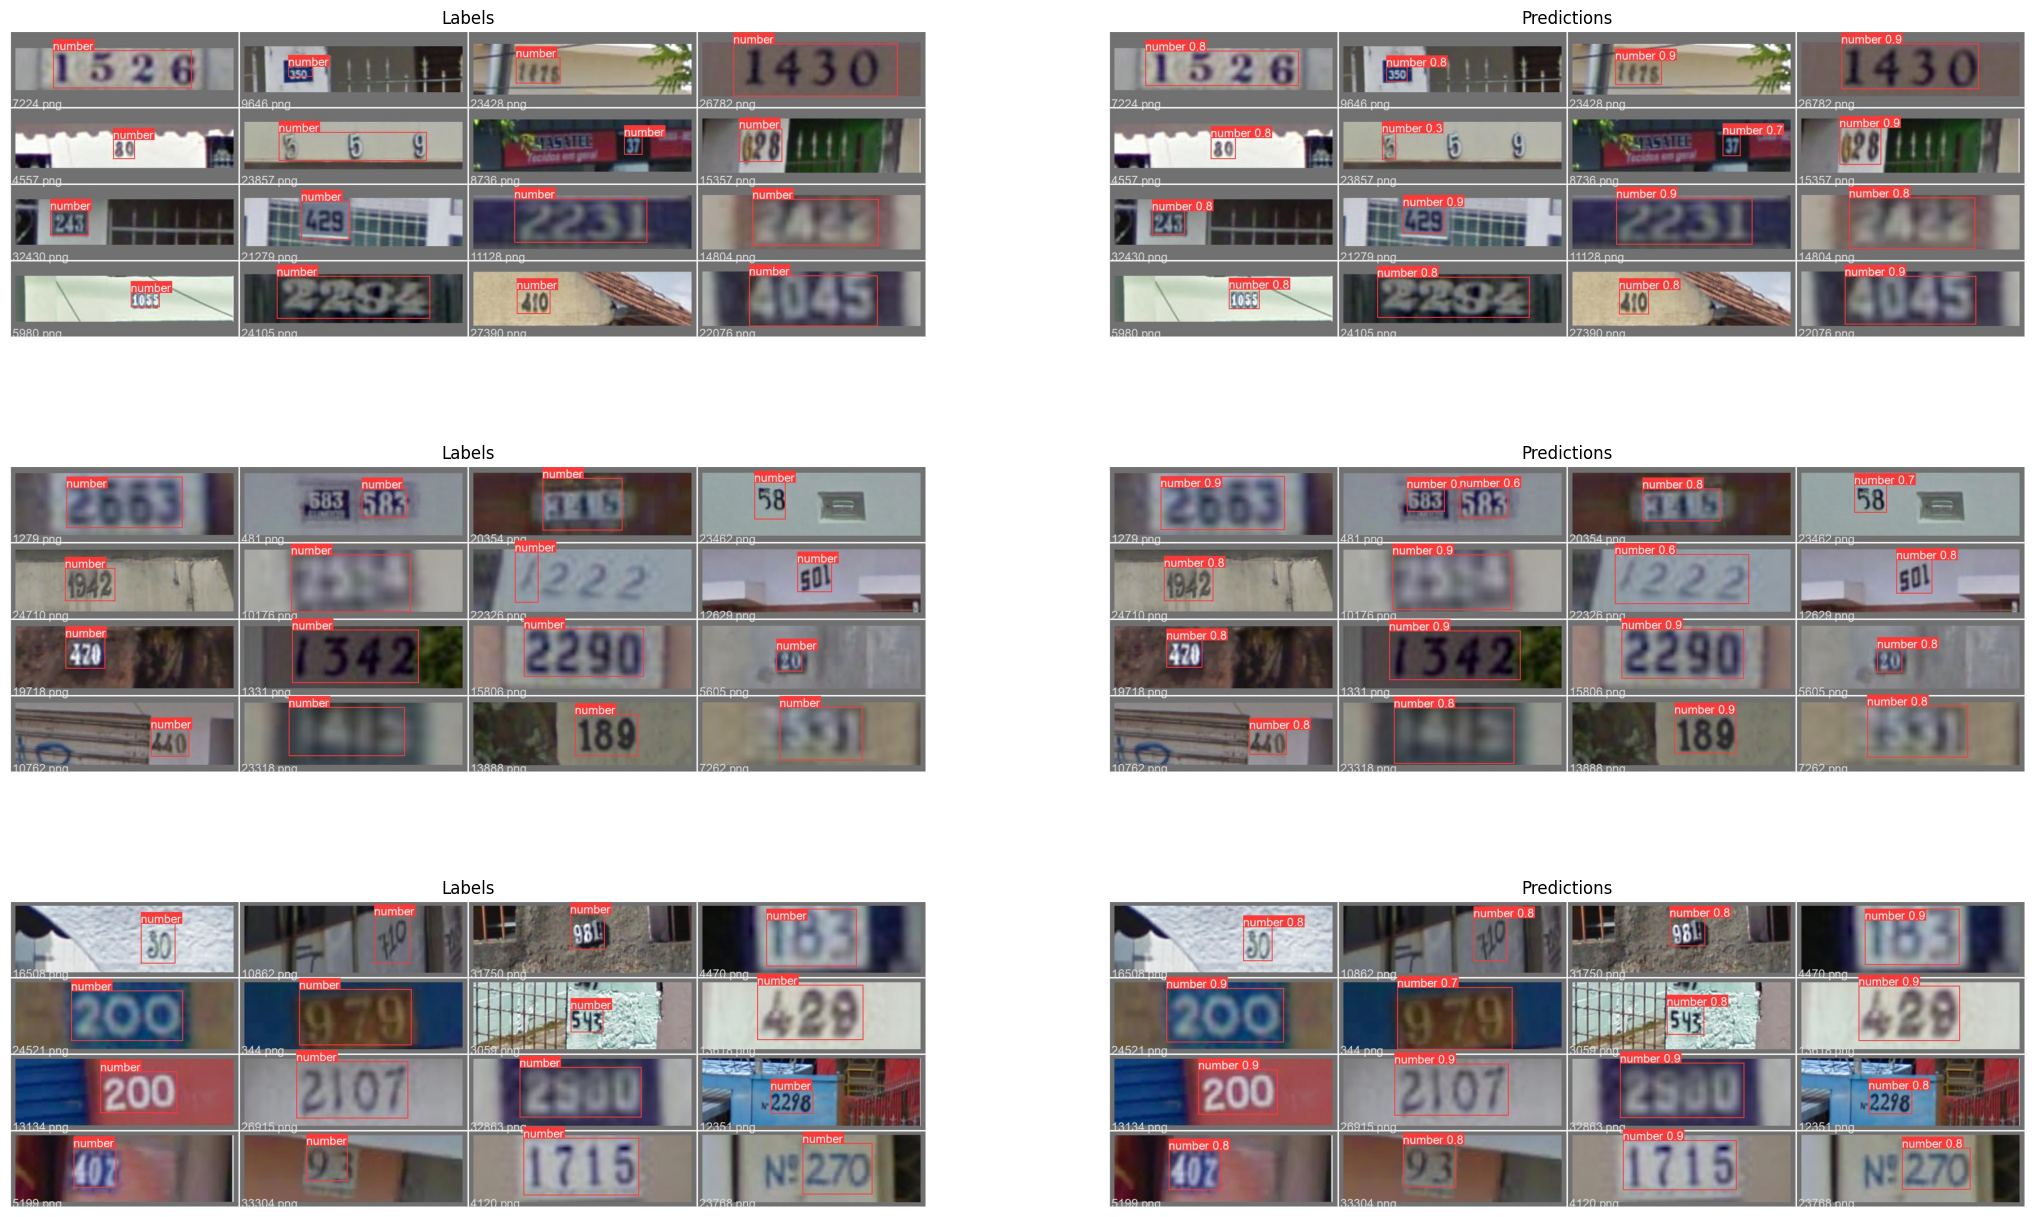

In [23]:
EXP_DIR = Path("./yolov5/runs/train/exp")
n_samples = 3
fig, axs = plt.subplots(n_samples, 2, figsize=(26, 16))

for i in range(n_samples):
    labels = Image.open(EXP_DIR / f"val_batch{i}_labels.jpg")
    preds = Image.open(EXP_DIR / f"val_batch{i}_pred.jpg")

    axs[i, 0].axis("off")
    axs[i, 0].set_title("Labels")
    axs[i, 0].imshow(labels)

    axs[i, 1].axis("off")
    axs[i, 1].set_title("Predictions")
    axs[i, 1].imshow(preds)

In [24]:
# yolov5s 10 epochs
! PYTHONPATH=$PWD/yolov5 python ./yolov5/val.py \
    --weights ./yolov5/runs/train/exp/weights/best.pt \
    --data digits.yaml \
    --img 640 \
    --batch-size 128 \
    --conf-thres 0.4 \
    --iou-thres 0.4 \
    --task test \
    --device 0 \
    --workers 4

val: data=/home/and/projects/itmo/itmo_image_rec_gen/02_object_detection/yolov5/data/digits.yaml, weights=['./yolov5/runs/train/exp/weights/best.pt'], batch_size=128, imgsz=640, conf_thres=0.4, iou_thres=0.4, task=test, device=0, workers=4, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.2-0-gd3ea0df8 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3080 Ti, 12052MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning '/home/and/projects/itmo/itmo_image_rec_gen/02_object_detection/d
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all      13068      13068      0.917      0.893      0.918       0.56
Speed: 0.1ms pre-process, 0.7ms inference, 0.5ms NMS per image at shape (128, 3, 640, 640)
Results saved to yolov5/runs/val/

In [25]:
! PYTHONPATH=$PWD/yolov5 python ./yolov5/export.py \
    --weights ./yolov5/runs/train/exp/weights/best.pt \
    --include torchscript

export: data=yolov5/data/coco128.yaml, weights=['./yolov5/runs/train/exp/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, train=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript']
YOLOv5 🚀 v6.2-0-gd3ea0df8 Python-3.10.8 torch-1.13.0+cu117 CPU

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from yolov5/runs/train/exp/weights/best.pt with output shape (1, 25200, 6) (13.8 MB)

TorchScript: starting export with torch 1.13.0+cu117...
TorchScript: export success, saved as yolov5/runs/train/exp/weights/best.torchscript (27.2 MB)

Export complete (1.69s)
Results saved to /home/and/projects/itmo/itmo_image_rec_gen/02_object_detection/yolov5/runs/train/exp/weights
Detect:          python detect.py --weights yol

# Inference

In [3]:
import sys
sys.path.append("./yolov5")

In [26]:
from yolov5.utils.general import non_max_suppression, scale_coords
from yolov5.utils.dataloaders import letterbox

SAMPLES_DIR = Path("./test_samples")
WEIGHTS_DIR = Path("./yolov5/runs/train/exp/weights")
CONF_THRESH = 0.4
IOU_THRESH = 0.4
detector = torch.jit.load(WEIGHTS_DIR / "best.torchscript", map_location=DEVICE)
detector.eval()


def preprocess(img):
        img_shape = img.shape
        img, ratio, pad = letterbox(img, new_shape=(640, 640), auto=False)
        tensor = img[:, :, ::-1].transpose(2, 0, 1)  
        tensor = np.ascontiguousarray(tensor, dtype=np.float32)
        tensor = torch.from_numpy(tensor).to(DEVICE, non_blocking=True)
        tensor /= 255.0
        if tensor.ndimension() == 3:
            tensor = tensor.unsqueeze(0)
        return tensor.to(DEVICE), img_shape


def postprocess(model_output, input_shapes):
    preds = non_max_suppression(model_output, CONF_THRESH, IOU_THRESH)
    for pred, input_shape in zip(preds, input_shapes):
        pred[:, :4] = scale_coords(
            (640, 640), 
            pred[:, :4], 
            input_shape
        ).round()
    return [p.cpu().numpy() for p in preds]

images_paths = sorted(list(SAMPLES_DIR.iterdir()))
images = [
    preprocess(cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB))
    for p in images_paths
]
input_tensor = [tensor for tensor, _ in images]
img_shapes = [img_shape for _, img_shape in images]
images = torch.cat(input_tensor)
images.shape

torch.Size([6, 3, 640, 640])

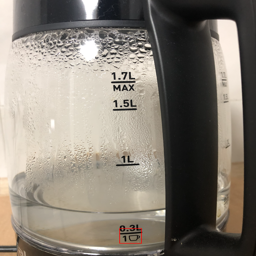

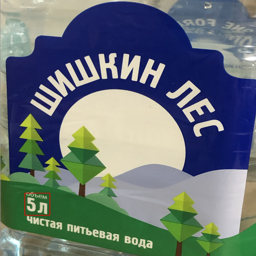

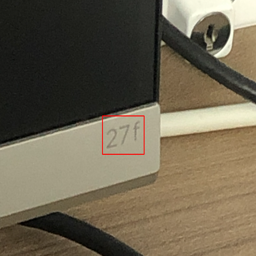

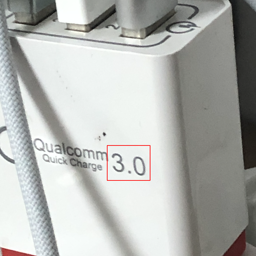

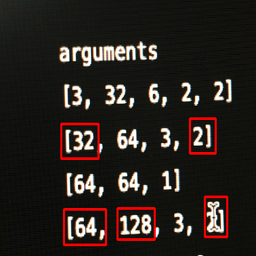

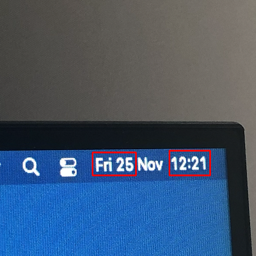

In [27]:
predictions = detector(images)[0]
predictions = postprocess(predictions, img_shapes)
for i in range(len(images_paths)):
    display(plot_img(images_paths[i], predictions[i], verbose=False).resize((256, 256)))